# Partial Least Squares

### Import necessary modules for PLS

In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.cross_decomposition import PLSRegression
from sklearn.impute import KNNImputer, SimpleImputer
from sklearn.metrics import mean_squared_error, r2_score, root_mean_squared_error
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import RepeatedKFold, train_test_split, GridSearchCV, learning_curve, KFold

### Load dataframe

In [8]:
Xtrain = pd.read_csv("Xytrain_regression.csv").iloc[:, 2:]
ytrain = pd.read_csv("Xytrain_regression.csv").iloc[:, 1]

Xtest = pd.read_csv("Xytest_regression.csv").iloc[:, 2:]
ytest = pd.read_csv("Xytest_regression.csv").iloc[:, 1]

n, p = Xtrain.shape
print(f"Shape of Xtrain: {n} samples, {p} features")
print(f"Shape of Xtest: {Xtest.shape[0]} samples, {Xtest.shape[1]} features")
Xtrain.head(3)

Shape of Xtrain: 80 samples, 116 features
Shape of Xtest: 20 samples, 116 features


,x_01,x_02,x_03,x_04,x_05,x_06,x_07,x_08,x_09,x_10,...,C_04_71.0,C_04_72.0,C_04_73.0,C_04_74.0,C_04_75.0,C_05_71.0,C_05_72.0,C_05_73.0,C_05_74.0,C_05_75.0
0,0.841004,-0.684825,0.914453,0.369843,0.287951,-0.269598,-1.532422,0.202755,0.598845,0.555123,...,0,0,0,1,0,0,0,0,1,0
1,-0.183416,0.994827,0.274484,0.896056,0.338138,-0.632974,0.869122,0.173345,-0.045464,0.914123,...,0,0,0,0,1,0,0,0,0,1
2,-2.395578,0.377075,-2.004454,-1.467210,-0.523651,-0.102531,0.665450,-1.379531,-1.303042,-0.096789,...,0,0,0,1,0,0,0,1,0,0


### PLS

Mean Squared Error: 1316.629452334797
R-squared: 0.7442187654432681
Root Mean Squared Error: 36.285388964909785


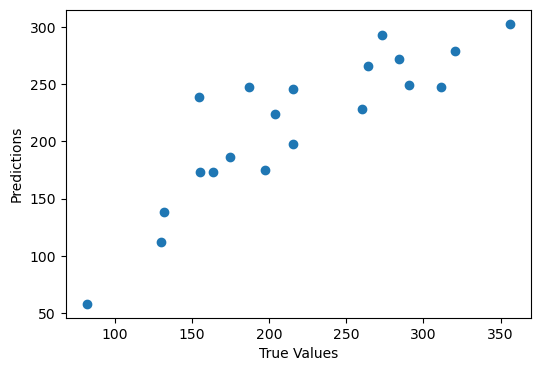

In [13]:
# Initialize and fit the PLS model
pls = PLSRegression(n_components=4)  # Choose the number of components
pls.fit(Xtrain, ytrain)

# Make predictions
y_pred = pls.predict(Xtest)

# Evaluate the model
mse = mean_squared_error(ytest, y_pred)
r2 = r2_score(ytest, y_pred)
rmse = root_mean_squared_error(ytest, y_pred)
print(f'Mean Squared Error: {mse}')
print(f'R-squared: {r2}')
print(f'Root Mean Squared Error: {rmse}')

# Plot the results
plt.figure(figsize=(6, 4))
plt.scatter(ytest, y_pred)
plt.xlabel("True Values")
plt.ylabel("Predictions")
plt.show()

Best parameters for Ridge:  {'n_components': 10}
Best cross-validation score: 0.7332
R² Score on the test dataset: 0.7708
MSE on the test dataset: 1179.6476
RMSE on the test dataset: 34.3460


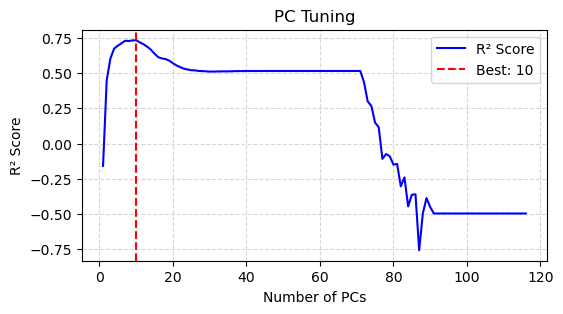

Best estimator: PLSRegression(n_components=10, scale=False)


In [14]:
# Initialize and fit the PLS model
pls = PLSRegression(scale=False)  # the data is already normalized

# Define the hyperparameter grid for alpha
param_pls_pc = {
    'n_components': range(1, p+1)
    }

# Define KFold cross-validation
cv = KFold(n_splits=10, shuffle=True, random_state=42)

# Use GridSearchCV with the KFold object
PLS_ = GridSearchCV(pls, param_pls_pc, cv=cv, n_jobs=-1, return_train_score=True, scoring='r2')

# Fit the GridSearchCV
PLS_.fit(Xtrain, ytrain)

# Print best parameters and best cross-validation score
print("Best parameters for Ridge: ", PLS_.best_params_)
print("Best cross-validation score: {:.4f}".format(PLS_.best_score_))

# Evaluate the best model on the test data
best_model_ridge = PLS_.best_estimator_
y_pred_pls = best_model_ridge.predict(Xtest)

# Calculate R² score on test set
test_R2 = r2_score(ytest, y_pred_pls)
test_MSE = mean_squared_error(ytest, y_pred_pls)
test_RMSE = root_mean_squared_error(ytest, y_pred_pls)

print("R² Score on the test dataset: {:.4f}".format(test_R2))
print("MSE on the test dataset: {:.4f}".format(test_MSE))
print("RMSE on the test dataset: {:.4f}".format(test_RMSE))

# Get the mean test scores from the cross-validation results
n_components = range(1, p+1)
mean_test_scores = PLS_.cv_results_['mean_test_score']

# Plot the results of hyperparameter tuning
plt.figure(figsize=(6, 3))
plt.plot(n_components, mean_test_scores, linestyle='-', color='b', label='R² Score')
plt.axvline(PLS_.best_params_['n_components'], color='r', linestyle='--', label=f"Best: {PLS_.best_params_['n_components']}")
plt.xlabel('Number of PCs')
plt.ylabel('R² Score')
plt.title('PC Tuning')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()

# Print best estimator
print(f'Best estimator: {PLS_.best_estimator_}')

In [17]:
# Get the mean test R² scores and standard deviations
meanError = list(PLS_.cv_results_['mean_test_score'])
stdError = PLS_.cv_results_['std_test_score']

# Find the index of the model with the highest mean R² score
maxAcc = meanError.index(max(meanError))

# Apply the One Standard Error Rule to find acceptable models
J = np.where(meanError[maxAcc] - stdError[maxAcc] < meanError)[0]

# Select the model with the highest alpha (if there are multiple models that satisfy the condition)
if len(J) > 0:
    j = int(J[-1])  # Select the most regularized model (simpler)
else:
    j = maxAcc  # If no model satisfies the rule, keep the best one

# Print the hyperparameters of the selected model
print(f'One standard error rule selects model with alpha: {PLS_.cv_results_["param_n_components"][j]}')
print(f'One standard error rule gives the best model with mean_test_score (R²): {meanError[j]} and std_test_score: {stdError[j]}')

One standard error rule selects model with alpha: 15
One standard error rule gives the best model with mean_test_score (R²): 0.6378060398045496 and std_test_score: 0.15815803195986639


In [20]:
n_components = PLS_.cv_results_["param_n_components"][j]

# Ridge Model (alpha=10)
PLS_ = PLSRegression(n_components=n_components)
PLS_.fit(Xtrain, ytrain)
y_pred_pls = PLS_.predict(Xtest)

df_compare = pd.DataFrame({
    'Actual': ytest,
    'Predicted': y_pred_pls,
    'Squared Error (SE)': (ytest - y_pred_pls) ** 2,  # Squared error
    'Absolute Error (AE)': np.abs(ytest - y_pred_pls)  # Absolute error
})

mse = df_compare["Squared Error (SE)"].mean()
rmse = np.sqrt(mse)

r2_ridge = r2_score(ytest, y_pred_pls)
print(f'R² score for Ridge: {r2_ridge:.4f}')

print(f"Mean Squared Error (MSE): {mse:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")

std_actual = df_compare["Actual"].std()
print(f"Standard Deviation of Actual Values: {std_actual:.2f}")

#If RMSE < std_actual: The model is reasonably good.
#If RMSE ≈ std_actual: The model is performing just like a simple average prediction.
#If RMSE > std_actual: The model is performing poorly

R² score for Ridge: 0.6936
Mean Squared Error (MSE): 1577.19
Root Mean Squared Error (RMSE): 39.71
Standard Deviation of Actual Values: 73.61
